# Data Cleansing and Preparation:
## The following data cleansing and preparation steps were followed by the work in the source below:
### https://www.kaggle.com/code/ahmedislam0/phishing-url-detection-96-accuracy
## The Support Vector classifier Machine model implementation, analysis, and evaluation are unique to this notebook.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pickle
pd.set_option('display.max_columns', None)

In [32]:
# Import Dataset
df = pd.read_csv('../../../data/dataset_phishing.csv')
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


# How many of these columns have null columns? If null we need to remove them.

In [35]:
df.isna().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

In [37]:
# removing missing values

df.dropna(inplace=True)

# Set up an array of the features "the columns" we want to include in our study.

In [40]:
features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq',
    'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn',
    'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
    'ratio_digits_host', 'punycode', 'shortening_service', 'path_extension', 'phish_hints', 'domain_in_brand',
    'brand_in_subdomain', 'brand_in_path', 'suspecious_tld'
]

In [42]:
# Target feature mapping, meaning mapping our known answers to a numeric value.

df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

# Verifying that we have a perfectly balanced data set for training, 5715 phishing and legitimate entries. 

In [45]:
df['status'].value_counts()

status
0    5715
1    5715
Name: count, dtype: int64

# Gives general information about the dataset

In [48]:
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.00000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,0.322660,0.006649,0.123097,4.289589,0.000700,1.027909,0.004024,0.062292,0.001925,0.034821,0.448469,0.127997,0.006562,0.016710,0.610936,0.053137,0.025024,0.000350,0.002362,0.065617,0.050131,0.021610,2.231671,0.202450,0.083290,0.123447,0.000175,0.498250,0.003150,6.232808,2.927472,3.127297,5.019773,2.398950,15.393876,10.467979,10.561505,7.258882,7.678075,5.092425,0.327734,0.104199,0.004112,0.004899,0.017935,0.059755,87.189764,0.602457,0.276720,0.0,0.784864,0.0,0.158926,0.0,0.062469,0.063605,0.442170,51.978211,0.0,42.870444,23.236293,0.0,0.001312,0.006037,37.063922,0.001137,0.00140,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,1.093336,0.081274,1.466450,1.882251,0.026448,0.240325,0.103240,0.598190,0.077111,0.375576,0.501912,0.379008,0.080742,0.169358,0.487559,0.089363,0.093422,0.018705,0.048547,0.247622,0.218225,0.145412,0.637069,0.401843,0.276332,0.328964,0.013227,0.691907,0.056035,5.572355,4.768936,2.211571,3.941580,2.997809,22.083644,4.932015,23.077883,4.145827,3.578435,7.147050,0.842600,0.305533,0.063996,0.069827,0.132722,0.331266,166.758254,0.376474,0.319958,0.0,2.758802,0.0,0.266437,0.0,0.156209,0.244058,0.496666,41.523144,0.0,46.249897,38.386577,0.0,0.036204,0.077465,39.073385,0.033707,0.03739,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.0000

# Gives number of rows, number of columns

In [51]:
df.shape

(11430, 89)

# Gives information about the datatypes for the features, non-null values

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [56]:
# Select only the numerical columns from the dataframe that are float64 or int64 to rull out objects.
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix on the numerical columns.
corr_matrix = numerical_df.corr()

In [58]:
status_corr = corr_matrix['status']
status_corr.shape

(88,)

In [60]:
# Function for selecting features that are above than threshold value

def feature_selector_correlation(cmatrix, threshold):

    selected_features = []
    feature_score = []
    i=0
    for score in cmatrix:
        if abs(score)>threshold:
            selected_features.append(cmatrix.index[i])
            feature_score.append( ['{:3f}'.format(score)])
        i+=1
    result = list(zip(selected_features,feature_score))
    return result

In [62]:
features_selected = feature_selector_correlation(status_corr, 0.2)
features_selected

[('length_url', ['0.248580']),
 ('length_hostname', ['0.238322']),
 ('ip', ['0.321698']),
 ('nb_dots', ['0.207029']),
 ('nb_qm', ['0.294319']),
 ('nb_eq', ['0.233386']),
 ('nb_slash', ['0.242270']),
 ('nb_www', ['-0.443468']),
 ('ratio_digits_url', ['0.356395']),
 ('ratio_digits_host', ['0.224335']),
 ('tld_in_subdomain', ['0.208884']),
 ('prefix_suffix', ['0.214681']),
 ('shortest_word_host', ['0.223084']),
 ('longest_words_raw', ['0.200147']),
 ('longest_word_path', ['0.212709']),
 ('phish_hints', ['0.335393']),
 ('nb_hyperlinks', ['-0.342628']),
 ('ratio_intHyperlinks', ['-0.243982']),
 ('empty_title', ['0.207043']),
 ('domain_in_title', ['0.342807']),
 ('domain_age', ['-0.331889']),
 ('google_index', ['0.731171']),
 ('page_rank', ['-0.511137']),
 ('status', ['1.000000'])]

In [64]:
selected_features = []
for feature, score in features_selected:
    if feature != 'status':
        selected_features.append(feature)

In [66]:
selected_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_qm',
 'nb_eq',
 'nb_slash',
 'nb_www',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'prefix_suffix',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_path',
 'phish_hints',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'empty_title',
 'domain_in_title',
 'domain_age',
 'google_index',
 'page_rank']

In [68]:
X = df[selected_features]
y = df['status']

# Initial attempt running SVR was not practical 
Evaluation Metrics: For each SVR model, the Mean Squared Error (MSE) for each fold and the average MSE across all folds are calculated and displayed. MSE measures the average squared difference between the predicted and actual values, providing insight into how well the model fits the data. The lower the MSE, the better the model's performance.

```
Evaluating Linear SVR (Regression)...
Mean Squared Error for each fold: [0.08057713 0.0970103  0.08890391 0.11476004 0.09522179 0.08236009
 0.09227233 0.10726277 0.08900387 0.09991692]
Mean MSE: 0.09472891500456572

Evaluating RBF SVR (Regression)...
Mean Squared Error for each fold: [0.03366636 0.04174458 0.03246224 0.04136156 0.03639699 0.03664976
 0.03507766 0.03799333 0.03100592 0.03713072]
Mean MSE: 0.03634891147769166

Evaluating Polynomial SVR (Regression)...
Mean Squared Error for each fold: [ 0.22356538  0.14846463  0.07776988  0.23715208  0.12105632  0.75250931
  0.59332727 46.54879139  0.08521166  0.12293362]
Mean MSE: 4.891078153530154
```

# Why SVC is better for classification: SVC is optimized to create decision boundaries that cleanly divide data points of different classes, making it more effective for classification problems. SVR does not work to create decision boundaries between classe
Support Vector Classification (SVC) and Support Vector Regression (SVR) are both based on the Support Vector Machine (SVM) algorithm, but they are designed for different types of tasks—classification and regression, respectively. Here's why SVC is better than SVR for classification tasks:

## 1. Task Type and Objective
SVC (Support Vector Classification): SVC is designed to solve classification problems, where the goal is to assign inputs to discrete categories or labels (e.g., "spam" or "not spam", "benign" or "malware"). SVC works by finding the optimal hyperplane that separates different classes with the maximum margin between the closest points of each class (called support vectors).
SVR (Support Vector Regression): SVR, on the other hand, is used for regression tasks, where the goal is to predict continuous values (e.g., predicting the price of a house). SVR finds a hyperplane that best fits the data points within a specified margin of error.
Why SVC is better for classification: For classification tasks, SVC directly aims to separate data into different classes with clear boundaries. SVR is not meant for classification because it tries to predict a continuous output, not assign discrete labels.

## 2. Handling Discrete Labels vs. Continuous Targets
SVC: SVC is inherently designed to handle discrete labels (e.g., class 0, class 1), where the model focuses on finding the decision boundary between different classes.
SVR: SVR is meant to handle continuous targets, focusing on predicting a real number (e.g., price, temperature).
Why SVC is better for classification: Since classification involves predicting discrete classes rather than continuous values, SVC is a natural fit for this task. SVR would not be able to classify inputs into categories because it outputs continuous values.



# ACTUAL SVC CROSS-VALIDATION and Classification Metrics Analysis HERE
This code performs 10-fold cross-validation on a dataset using various configurations of Support Vector Classifier (SVC) models, evaluating their performance with accuracy, confusion matrix, and classification report.

1. SVC Configurations:
- Linear Kernel SVC: Assumes a linear decision boundary between the classes in the feature space.
- RBF Kernel SVC: Uses the Radial Basis Function to capture non-linear decision boundaries between classes by mapping the features into a higher-dimensional space.
- Polynomial Kernel SVC: Uses polynomial decision boundaries, allowing the model to capture more complex class relationships and interactions.

2. Cross-Validation:
- The `cross_val_predict` function is used to perform 10-fold cross-validation, where the dataset is split into 10 subsets (folds). The model is trained on 9 subsets and evaluated on the remaining subset, repeating this process across all 10 folds.
- This process ensures a robust evaluation, providing insights into the model's generalization performance across different data splits.

3. Evaluation Metrics:
- Accuracy: Measures the proportion of correctly classified instances out of the total instances. The mean accuracy across all 10 folds is calculated to provide a measure of overall model performance.
- Confusion Matrix: Shows the number of true positive, true negative, false positive, and false negative predictions, offering insights into how well the model distinguishes between the classes.
- Classification Report: Provides detailed metrics, including precision, recall, F1-score, and support for each class, helping to assess the quality of predictions for each class individually.

By applying 10-fold cross-validation and calculating accuracy, confusion matrix, and classification metrics, this code evaluates how well each SVC model performs on classification tasks, allowing for comparison between different kernel functions (linear, RBF, and polynomial).

============================== SVC with linear kernel Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.93788276 0.9256343  0.94575678 0.92125984 0.93613298 0.9343832
 0.92825897 0.92650919 0.94575678 0.9343832 ]
Mean Accuracy across folds: 0.9336
Model Accuracy (combined prediction): 93.36%
Confusion Matrix:
 [[5353  362]
 [ 397 5318]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      5715
           1       0.94      0.93      0.93      5715

    accuracy                           0.93     11430
   macro avg       0.93      0.93      0.93     11430
weighted avg       0.93      0.93      0.93     11430




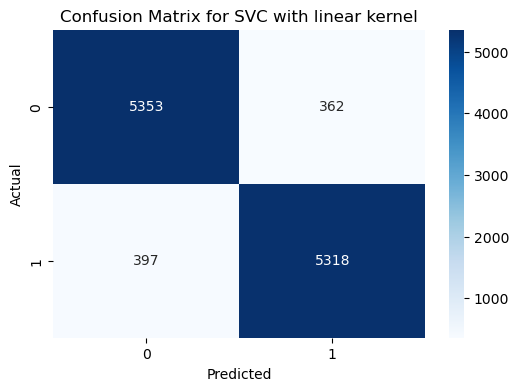

============================== SVC with RBF kernel Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.96325459 0.94838145 0.96062992 0.95538058 0.95538058 0.95625547
 0.95888014 0.9536308  0.96937883 0.95275591]
Mean Accuracy across folds: 0.9574
Model Accuracy (combined prediction): 95.74%
Confusion Matrix:
 [[5479  236]
 [ 251 5464]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5715
           1       0.96      0.96      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




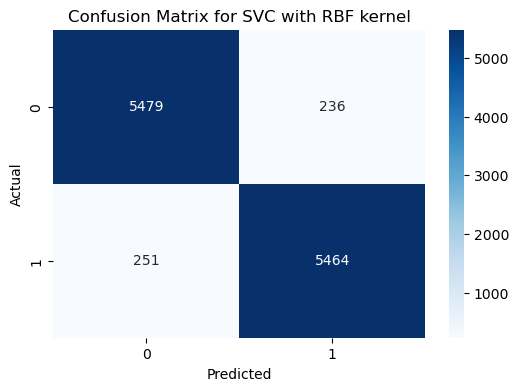

============================== SVC with polynomial kernel Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.94663167 0.93788276 0.95625547 0.94750656 0.93875766 0.94575678
 0.94138233 0.94313211 0.9536308  0.94925634]
Mean Accuracy across folds: 0.9460
Model Accuracy (combined prediction): 94.60%
Confusion Matrix:
 [[5450  265]
 [ 352 5363]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      5715
           1       0.95      0.94      0.95      5715

    accuracy                           0.95     11430
   macro avg       0.95      0.95      0.95     11430
weighted avg       0.95      0.95      0.95     11430




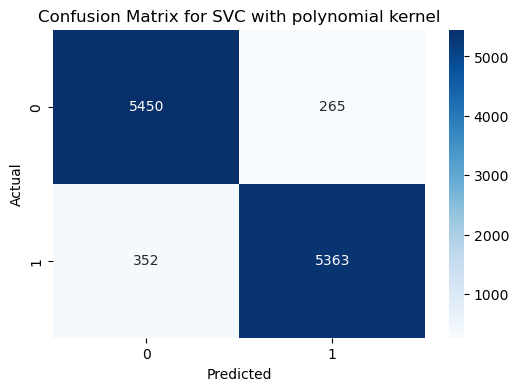

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Assuming X is your feature matrix and y is your target variable (classification labels)
# X = df[selected_features]
# y = df['target_variable']

# Initialize the StandardScaler and scale the entire feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define different SVC models for classification tasks
models = [
    ('SVC with linear kernel', SVC(kernel='linear', C=1, random_state=0)),
    ('SVC with RBF kernel', SVC(kernel='rbf', C=1, gamma=0.1, random_state=0)),
    ('SVC with polynomial kernel', SVC(kernel='poly', degree=3, C=1, random_state=0))
]

# Function to evaluate SVC models using cross-validation for classification
def evaluate_classification_model(model, X, y, model_name):
    print(f'============================== {model_name} Cross-Validation Evaluation ==============================')
    
    # Perform 10-fold cross-validation and predict using cross_val_predict
    y_pred = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
    
    # Calculate Accuracy, Confusion Matrix, and Classification Report
    accuracy = accuracy_score(y, y_pred)
    confusion_matrix_result = confusion_matrix(y, y_pred)
    classification = classification_report(y, y_pred)
    
    # Perform 10-fold cross-validation to get accuracy for each fold
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1)
    
    # Print evaluation results
    print(f"Accuracy for each fold: {scores}")
    print(f"Mean Accuracy across folds: {np.mean(scores):.4f}")
    print(f"Model Accuracy (combined prediction): {accuracy * 100:.2f}%")
    print('Confusion Matrix:\n', confusion_matrix_result)
    print('Classification Report:\n', classification)
    print()

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Iterate through each SVC model and evaluate using cross-validation
for model_name, model in models:
    evaluate_classification_model(model, X_scaled, y, model_name)